In [1]:
import category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
#pd.options.display.max_rows = 100 #Para controlar cuantas filas de los dataframes mostrar.
#pd.options.display.max_columns = 200 #Para controlar cuantas columnas de los dataframes mostrar.
import warnings
warnings.filterwarnings('ignore') #Para ignorar (o no) las advertencias.

**AQUÍ SOLO SE MUESTRAN TRATAMIENTOS QUE HAY QUE HACERLE A LOS DATOS CON SUS RESPECTIVOS RESULTADOS. NO OBSTANTE, LUEGO HAY QUE METER ESTO EN UN COLUMN TRANSFORMER Y DESPUÉS EN UNA PIPELINE.**

In [2]:
#Primero, leemos el archivo csv. Está separado por puntos y comas.
datos = pd.read_csv('pokemon-data.csv',delimiter =';')
y = datos.loc[:,'Tier'].copy()
X = datos.loc[:,datos.columns != 'Tier'].copy()
#X

In [3]:
#Vamos a modificar el índice de las filas
X.index = X['Name']
y.index = X['Name']

Para reducir el numero de clases para la variable de salida, juntamos los Pokemons en "Buenos" y "Malos". La categoría de "buenos" va a ser nuestra categoría "positiva", ya que es la que menos ejemplos posee, pero a su vez es la más interesante, ya que los jugadores competitivos quieren saber qué Pokémon son los mejores. Consideramos que un Pokémon es "bueno" (le asignaremos el valor 1) si está en OU, UBER o AG. De lo contrario, lo consideraremos "malo" (le asignaremos el valor 0).

In [4]:
class TierCathegorizer(TransformerMixin):
    def transform(self,X,y=None):
        X = pd.DataFrame(X)
        yaux = X.copy()
        tiers = np.where(np.logical_or(yaux.loc[:,'Tier'] == 'OU', yaux.loc[:,'Tier'] == 'Uber', yaux.loc[:,'Tier'] == 'AG'), 1, 0)
        yaux.loc[:,'Tier'] = tiers
        return yaux

In [84]:
#Aplicamos la transformación en dos clases. Buenos y malos
pipe = Pipeline([('tier',TierCathegorizer())])
y_transformed = pipe.transform(y)

Juntamos los movimientos en una nueva columna que está compuesta por el número de movimientos. Sin embargo, el Pokemon Smeargle es una excepción porque puede aprender todos los movimientos, pero esto no está reflejado en la base de datos (Aparece con sólo 10 movimientos).

In [7]:
class MovementCounter(TransformerMixin):
    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        Xaux = X.copy()
        Xaux['Moves'] = Xaux['Moves'].astype(str).str.count(',') + 1
        Xaux.loc['Smeargle','Moves'] = 676
        return Xaux

In [8]:
pipe = Pipeline([('Movement', MovementCounter())])
X_Count = pipe.transform(X)
#X_Count

Nos interesa desdoblar las columnas de los tipos, ya que hay muchas combinaciones de tipos diferentes. Al desdoblar la columna de tipos, obtenemos dos variables que sólo pueden tener 18 categorías (tipo 2 tendrá 19 categorías ya que a los Pokémon que sólo tienen un tipo les asignaremos un segundo tipo "nulo"), lo cual nos va a dar más información sobre lo bueno que es cada tipo a la hora
de  determinar el potencial competitivo de un Pokémon. Para ello, creamos una clase `TypeCategorizer()`que se va a encargar de esto. Tiene los métodos `fit` y `transform`para poder utilziarse en una *Pipeline*.

In [43]:
class TypeCategorizer(TransformerMixin):
    # Constructor de la clase
    def __init__(self, columns=None): #Si recibimos algo
        self.columns = columns

    #Fit
    def fit(self, X):
        X=pd.DataFrame(X) #Por si recibiéramos un array de numpy
        if self.columns == None:
            self.columns=X.columns
        return self

    #Transform
    def transform(self, X):
        #Creamos una copia de X para no perder los datos originales
        Xaux=X.copy()
        #Accedemos a la columna de tipos, y rellenamos las columnas acorde
        for c in self.columns:
            caracteresAEliminar = ["[", "]", "'"]
            for char in caracteresAEliminar:
                Xaux.loc[:,c]= Xaux.loc[:,c].str.replace(char,'')
            #Después, para los Pokémon que solo tienen un tipo, vamos a añadirles un segundo tipo "nulo"
            Xaux[['Type 1', 'Type 2']] = Xaux.loc[:,c].str.split(',', expand=True) #Expand true para que cree dos nuevas columnas

            #Por último, hay que borrar la columna de "Types" original
            Xaux=Xaux.drop(["Types"], axis=1)
        return Xaux

In [44]:
categorizadorDeTipos = TypeCategorizer(columns = ["Types"])
categorizadorDeTipos.fit(X)
X_ConTipos = categorizadorDeTipos.transform(X)
#X_ConTipos

Vamos a realizar el mismo tratamiento para las habilidades. Es decir, vamos a generar tres columnas, una por cada habilidad (un Pokémon puede tener 1,2 ó 3 habilidades de las que escoger).

In [45]:
def countCaracter(text, character):
    apariciones=0
    for char in text:
        if char==character:
            apariciones+=1
    return apariciones

class AbilityCategorizer(TransformerMixin):
    # Constructor de la clase
    def __init__(self, columns=None): #Si recibimos algo
        self.columns = columns

    #Fit
    def fit(self, X):
        X=pd.DataFrame(X) #Por si recibiéramos un array de numpy
        if self.columns == None:
            self.columns=X.columns
        return self

    #Transform
    def transform(self, X):
        #Creamos una copia de X para no perder los datos originales
        Xaux=X.copy()
        #Accedemos a la columna de habilidades, y modificamos las columnas acorde
        for c in self.columns:
            caracteresAEliminar = ["[", "]", "'"]
            for char in caracteresAEliminar:
                Xaux.loc[:,c]= Xaux.loc[:,c].str.replace(char,'')
            #Para los Pokémon que tienen sólo una habilidad, vamos a añadirles dos habilidades nulas; y para los
            #que tengan 2 habilidades, les añadimos una extra.
            for poke in Xaux.loc[:,c].index:
                if countCaracter(Xaux.loc[poke,c], ",")==0:
                    Xaux.loc[poke,c]=Xaux.loc[poke,c]+", None, None"
                elif countCaracter(Xaux.loc[poke,c], ",")==1:
                    Xaux.loc[poke,c]=Xaux.loc[poke,c]+", None"
            #Creamos tres columnas nuevas
            Xaux[['Ability 1', 'Ability 2', 'Ability 3']] = Xaux.loc[:,c].str.split(',', expand=True)
            #Por último, hay que borrar la columna de "Abilities" original
            Xaux=Xaux.drop(["Abilities"], axis=1)
        return Xaux

In [46]:
categorizadorDeHabilidades = AbilityCategorizer(columns = ["Abilities"])
categorizadorDeHabilidades.fit(X_ConTipos)
X_ConTiposHabilidades = categorizadorDeHabilidades.transform(X_ConTipos)
#X_ConTiposHabilidades

Los nombres de los Pokémon no tienen relevancia competitiva, por lo que simplemente vamos a aplicar una codificación ordinal sobre esta columnna. Previsiblemente, al realizar la selección de variables, esta variable no será escogida, pero de igual forma necesitamos codificarla.

In [47]:
encodificadorOrdinal = ce.OrdinalEncoder(cols=["Name"])
#La entrenamos con el DataFrame sin datos faltantes
encodificadorOrdinal.fit(X_ConTiposHabilidades)
#Hacemos la transformación
X_ConTiposHabilidadesNombres=encodificadorOrdinal.transform(X_ConTiposHabilidades)
#X_ConTiposHabilidadesNombres

La columna de "siguientes evoluciones" puede tener relevancia ya que los Pokémon que todavía pueden evolucionar pueden utilizar un objeto llamado Mineral Evolutivo, que aumenta sus defensas en un 50%. No nos importa tanto si el Pokémon puede evolucionar una vez, dos veces o si tiene diferentes posibles evoluciones; solo si es capaz de evolucionar. Por lo tanto, codificaremos esta columna de la siguiente manera: si el Pokémon tiene alguna evolución posible, le asignaremos el valor 1; en caso contrario, le asignaremos el valor 0. Para ello, vamos a modificar la columna aplicándole dos tratamientos. Si la fila correspondiente es "[]", pondremos "´No", y en caso contrario pondremos "Si". Después, aplicaremos una codificación One Hot, adecuada ya que sólo generará una columna adicional al poder tomar esta variable solo dos valores.

Además, hay algunos Pokémon que pueden tener formas alternativas (que no se consideran evoluciones, por lo que no permiten el uso del Mineral Evolutivo) y que en el dataset presentan una lista no vacía en la columna de "siguientes evoluciones". Como no hay ningún criterio para detectar estos casos, los vamos a tratar manualmente. Estos Pokémon son **Giratina**, **Greninja**, **Kyurem**, **Landorus**, **Oricorio**, **Rotom**, **Shaymin**, **Thundurus**, **Tornadus** y **Zygarde**. Pese a que tengan una lista vacía, estos Pokémon los vamos a codificar como que **no** tienen evolución.

In [48]:
class EvolutionCategorizer(TransformerMixin):
    # Constructor de la clase
    def __init__(self, columns=None): #Si recibimos algo
        self.columns = columns

    #Fit
    def fit(self, X, y=0):
        X=pd.DataFrame(X) #Por si recibiéramos un array de numpy
        if self.columns == None:
            self.columns=X.columns
        return self

    #Transform
    def transform(self, X, y=0):
        #Creamos una copia de X para no perder los datos originales
        Xaux=X.copy()
        #Accedemos a la columna de tipos, y rellenamos las columnas acorde
        for c in self.columns:
            Xaux.loc[:,c] = np.where(Xaux.loc[:,c]=="[]", "No", "Si")
            #Ahora, consideramos las excepciones descritas arriba
            pokemonEquivocados = ["Giratina", "Greninja", "Kyurem", "Landorus", "Oricorio", "Rotom", "Shaymin", "Thundurus", "Tornadus", "Zygarde"]
            for poke in pokemonEquivocados:
                Xaux.loc[poke,c]="No"
        return Xaux

    #set_params
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

#Una vez aplicamos el EvolutionCategorizer(), aplicamos el One Hot Encoding. Para ello, hacemos una PipeLine
pipe_Evol =  Pipeline([('Categorizador de Evoluciones', EvolutionCategorizer(columns=["Next Evolution(s)"])), 
                       ('One Hot Encoding', ce.OneHotEncoder(cols = ["Next Evolution(s)"], handle_unknown="ignore"))])

In [49]:
pipe_Evol.fit(X_ConTiposHabilidadesNombres)
X_ConTiposHabilidadesNombresEvol = pipe_Evol.transform(X_ConTiposHabilidadesNombres)
#X_ConTiposHabilidadesNombresEvol

Para las 3 columnas de habilidades, vamos a emplear una codificación basada en la salida, puesto que estas variables pueden tomar potencialmente muchos valores (en séptima generación había 233 habilidades diferentes). Al igual que pasaba con los tipos, la habilidad de un Pokémon sí influye en su potencial competitivo, así que tiene sentido emplear esta codificación.

Para no castigar excesivamente a aquellas habilidades menos comunes, pero potencialmente interesantes desde un punto de vista competitivo, vamos a establecer el parámetro $a$ (*smoothing*) para que sea cercano a infinito ($a = 1000000 $). De esta forma, por ejemplo, si sólo dos Pokémon tienen una habilidad buena, pero esos dos Pokémon son "malos", podemos darle un valor diferente a 0 a esa habilidad. El parámetro `min_samples_leaf` lo mantenemos a 1 para que se pueda tener en cuenta $\frac{n_{c1}}{n}$ con un sólo ejemplo.

In [50]:
EncodificadorSalidaHabilidades = ce.TargetEncoder(cols = ["Ability 1", "Ability 2", "Ability 3"], smoothing=1, min_samples_leaf=1, handle_missing="value")
EncodificadorSalidaHabilidades.fit(X_ConTiposHabilidadesNombresEvol, y_transformed)
X_ConTiposHabilidadesNombresEvolHabilidad = EncodificadorSalidaHabilidades.transform(X_ConTiposHabilidadesNombresEvol)
#X_ConTiposHabilidadesNombresEvolHabilidad.iloc[0:100,:]

Las dos columnas de tipos, previamente separadas, son unos de los aspectos mas importantes a la hora de evaluar la viavilidad competitiva de un Pokémon. Entre todos ellos existe una tabla que dicta sus relaciones, mostranto sus resistencias, debilidades e inmunidades. Para este análisis solo vamos a tener en cuenta el aspecto defensivo, ya que el análisis de la ofensiva es mucho mas extenso. Para realizarlo seria necesario saber el tipo de cada movimiento (hay 913) y ver si coincide con alguno de los tipos del usuario, para poder aplicar un multiplicador de daño. Por lo mencionado, veremos que una combinación que defensivamente muestre muchas resistencias y pocas debilidades (**Acero** y **Hada**) se verá favorecida frente a los tipos mas débiles (**Bicho** y **Hielo**). Para ambas columnas vamos a utilizar una codificación basada en la salida **ONE HOT?**

**Solo aplicable para la basada en la salida**: Un aspecto importante a tener en cuenta es la manera en la que se han separado los tipos por columnas. En la columna *Type 1* estan los 18 tipos, mienstra que en *Type 2* se añade la posibilidad de esté vacía. Por ello, cada tipo obtiene distintos valores dependiendo de que columna esté. Los ejemplos mas claros son **Articuno** y **Abomasnow**. Ambos son de tipo hielo, sin embargo **Articuno**, al tenerlo de tipo primario **ACABALO**


In [55]:
#Con el fin de no favorecer a los tipos mas comunes, utilizamos un smoothing muy bajo

encodificadorSalidaTipos = ce.TargetEncoder(cols = ["Type 1", "Type 2"], smoothing  = 0.0000001, min_samples_leaf = 1)
X_ConTiposHabilidadesNombresEvolHabilidadTipos = encodificadorSalidaTipos.fit_transform(X_ConTiposHabilidadesNombresEvolHabilidad, y_transformed)
#X_ConTiposHabilidadesNombresEvolHabilidadTipos

#Elegir uno de los dos

In [56]:
#Con el fin de no favorecer a los tipos mas comunes, utilizamos un smoothing muy bajo
"""
encodificadorOneHotTipos = ce.OneHotEncoder(cols = ["Type"], use_cat_names=True)
X_ConTiposHabilidadesNombresEvolHabilidadTipos = encodificadorOneHotTipos.fit_transform(X_ConTiposHabilidadesNombresEvolHabilidad)

X_ConTiposHabilidadesNombresEvolHabilidadTipos #PENDIENTE DE LA RESPUESTA DE JOSEAN
"""

'\nencodificadorOneHotTipos = ce.OneHotEncoder(cols = ["Type"], use_cat_names=True)\nX_ConTiposHabilidadesNombresEvolHabilidadTipos = encodificadorOneHotTipos.fit_transform(X_ConTiposHabilidadesNombresEvolHabilidad)\n\nX_ConTiposHabilidadesNombresEvolHabilidadTipos #PENDIENTE DE LA RESPUESTA DE JOSEAN\n'

Dividimos los datos en: Conjunto de entrenamiento, validación y test.

In [87]:
# Creación de los conjuntos de test (10% de los ejemplos) y el resto de ejemplos
restoEjemplos_X, X_test, restoEjemplos_y, y_test =  train_test_split(X_ConTiposHabilidadesNombresEvolHabilidadTipos.loc[:,:], y_transformed.loc[:], test_size=0.10, random_state=123)

# Creación de los conjuntos de train (80% de los ejemplos) y de validación (resto de los ejemplos)
X_train, X_val, y_train, y_val =  train_test_split(restoEjemplos_X,restoEjemplos_y, train_size=0.80, test_size=0.20, random_state=123)
#print(f"X_test: {X_test}, y_test: {y_test},X_train: {X_val}, y_train: {y_val}")

Buscamos Outliers entre los datos mediante el método del rango intercuartílico. Sin embargo, puede tener sentido no borrar los outliers debido a que las estadísticas de los Pokemons no son mediciones sino sus valores "reales".

In [88]:
# Creamos la clase de detección y tratamiento de Outliers
class OutlierDetecion_treatment_IQR(TransformerMixin):
    nombresVariablesNum = ['HP', 'Attack', 'Defense', 'Special Attack', 'Special Defense','Speed']
    # Constructor de la clase
    def __init__(self, k=1.5, columns=nombresVariablesNum):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.loc[:,self.columns].describe()
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calcula el IQR de cada variable
        IQRs = self.stats.loc['75%'] - self.stats.loc['25%']
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc['25%'] - self.k * IQRs
        limiteSup = self.stats.loc['75%'] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        print(limiteInf)
        print(limiteSup)
        menores = Xaux.loc[:,self.nombresVariablesNum] < limiteInf
        mayores = Xaux.loc[:,self.nombresVariablesNum] > limiteSup

        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = np.logical_or(menores[c] , mayores[c])
            # Si hay outliers
            if indices.any():
                # Los sustituimos por la mediana
                print("Se han encontrado outliers en la variable", c)
                print(Xaux.loc[indices, c])
                #Xaux.loc[indices, c] = self.stats.loc['50%', c]
        # Se devuelve el DataFrame modificado
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}

In [89]:
# Instanciamos la clase anterior (llamamos out_IQR al objeto), la entrenamos con los datos de train y transformamos el conjunto de train
out_IQR = OutlierDetecion_treatment_IQR(k = 3)
out_IQR = out_IQR.fit_transform(X_train)
#X_train_IQR


HP                -40.0
Attack            -80.0
Defense           -62.0
Special Attack    -85.0
Special Defense   -59.0
Speed             -90.0
dtype: float64
HP                 170.00
Attack             235.00
Defense            204.00
Special Attack     230.00
Special Defense    201.75
Speed              225.00
dtype: float64
Se han encontrado outliers en la variable HP
Name
Blissey      255
Wobbuffet    190
Guzzlord     223
Chansey      250
Name: HP, dtype: int64
Se han encontrado outliers en la variable Defense
Name
Shuckle         230
Steelix-Mega    230
Stakataka       211
Name: Defense, dtype: int64
Se han encontrado outliers en la variable Special Defense
Name
Shuckle    230
Name: Special Defense, dtype: int64


Ahora con el fin de facilitar el aprendizaje del modelo vamos a estandarizar los datos de las estadísticas. Ya que son variables numéricas con mucha desviación estándard (HP de Blissey (255) frente a los de Shedinja (1)). Por la gran cantidad de diferencias vamos a utilizar StandardScaler. Para que centre los datos en torno a una media de 0 y ajusta la dispersión con una desviación estándar de 1. Además, dado que las estadísticas base de los Pokémon pueden tener rangos muy diferentes (por ejemplo, PS frente a Velocidad), estandarizarlas permitirá que el modelo trate cada estadística de manera uniforme, sin que las más grandes dominen el entrenamiento.

In [90]:
stats_pk = ["HP", "Attack", "Defense", "Special Attack", "Special Defense", "Speed"]

estandarizador = preprocessing.StandardScaler()
X_train_IQR_estandarizado = X_train_IQR
X_train_IQR_estandarizado[stats_pk] = estandarizador.fit_transform(X_train_IQR.loc[:,stats_pk])

#X_train_IQR_estandarizado

# RE-MUESTREO DE DATOS (BALANCEO DEL PROBLEMA) <a class="anchor" id="1"></a>

Poor la naturaleza del problema, este se encuentra ampliamente desbalanceado. Siendo predominando la clase de "malos" Pokémons, nuestra clase negativa. Vamos a ver una representación de la diferencia entre ambas clases y su Imbalanced ratio  

In [107]:
#Contamos los pokémons de cada categoría
n_malos = y_transformed[y_transformed==0].count()[0]
n_buenos = y_transformed[y_transformed==1].count()[0]
n_malos_train = y_train[y_train==0].count()[0]
n_buenos_train = y_train[y_train==1].count()[0]


#Mostramos el número de cada categoría, tanto en el conjunto de datos como en el de entrenamiento
print("Conjunto de datos total:")
print("Malos: "+str(n_malos) + ", Buenos: "+str(n_buenos))

print("\nConjunto de datos de entrenamiento:")
print("Malos: "+str(n_malos_train) + ", Buenos: "+str(n_buenos_train))

#Imbalance ratio
IR = n_malos/n_buenos
print("\nImbalanced ratio datos totales: " + str(IR))

IR_train = n_malos_train/n_buenos_train
print("Imbalanced ratio conjunto entrenamiento: " + str(IR_train))

Conjunto de datos total:
Malos: 815, Buenos: 103

Conjunto de datos de entrenamiento:
Malos: 593, Buenos: 67

Imbalanced ratio datos totales: 7.912621359223301
Imbalanced ratio conjunto entrenamiento: 8.850746268656716


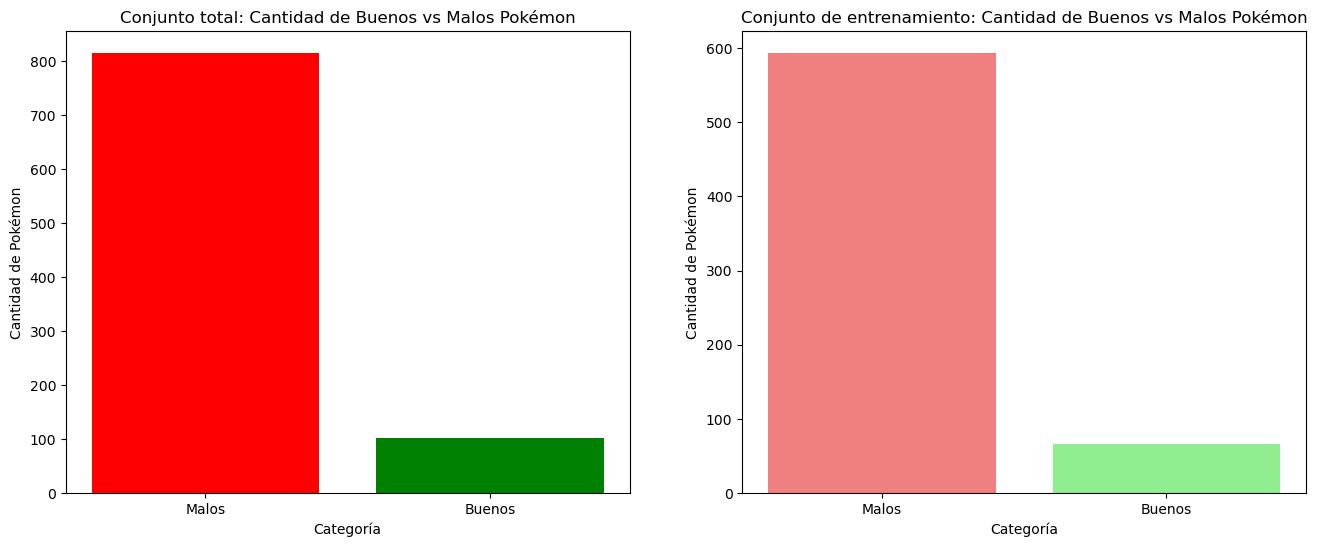

In [121]:
# Crear el histograma para buenos vs malos
plt.figure(figsize=(16, 6))

# Gráficos de barras de los Pokémons totales
plt.subplot(1,2,1)
plt.bar(['Malos', 'Buenos'], [n_malos, n_buenos], color=['red', 'green'])
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Pokémon')
plt.title('Conjunto total: Cantidad de Buenos vs Malos Pokémon')

# Gráficos de barras de los Pokémons del conjunto de entrenamiento
plt.subplot(1,2,2)
plt.bar(['Malos', 'Buenos'], [n_malos_train, n_buenos_train], color=['lightcoral', 'lightgreen'])
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Pokémon')
plt.title('Conjunto de entrenamiento: Cantidad de Buenos vs Malos Pokémon')

# Mostrar el gráfico
plt.show()

In [ ]:
Técnicas hibridas: SMOTE + Tomek Links